Get the prerequisites done

In [1]:
! pip install kaggle --upgrade --force

     |████████████████████████████████| 58 kB 3.0 MB/s 
     |████████████████████████████████| 149 kB 11.1 MB/s 
     |████████████████████████████████| 247 kB 57.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 138 kB 68.7 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 61 kB 7.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=832e9644cc9e66e11db04fda03caba4e67a723d0e28e506d0617ee3fe912a798
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: text-unidecode
    Found existing installation: text-unidecode 1.3
    Uninstal

In [2]:
import os
gce=False
if 'NO_GCE_CHECK' in os.environ:
  gce = True
if gce:
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'
else:
  pass

Mounted at /content/drive


In [3]:
! kaggle competitions download -c song-popularity-prediction

  0% 0.00/4.18M [00:00<?, ?B/s]
100% 4.18M/4.18M [00:00<00:00, 68.4MB/s]


In [4]:
! unzip song-popularity-prediction.zip

Archive:  song-popularity-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
! pwd

/content


In [6]:
! ls

drive	     sample_submission.csv	     test.csv
sample_data  song-popularity-prediction.zip  train.csv


In [732]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, RobustScaler, OrdinalEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import SCORERS, roc_auc_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.distributions import norm, lognorm, uniform
set_config(display='diagram')

In [733]:
np.random.seed(1)

In [734]:
df = pd.read_csv('train.csv').set_index("id")
test_df = pd.read_csv('test.csv').set_index("id")

In [735]:
df.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [736]:
def detect_outliers(df, threshold):
    # https://www.kaggle.com/kavehshahhosseini/spp-eda-feature-engineering-blending
    df = df.copy()
    threshold_z_score = stats.norm.ppf(threshold) # the 6 sigma plot, convert percentile (quantile) to Zscore.
    z_score_df = pd.DataFrame(np.abs(stats.zscore(df)), columns=df.columns)
    z_score_df = z_score_df > threshold_z_score # if greater than 99.99% of the data, count as outlier.
    outliers = z_score_df.sum(axis=1) # sum across columns along each row
    df["is_outlier"] = (outliers > 0).astype("uint8")
    return df

In [737]:
z_score_threshold = 0.9999

In [738]:
outlier_df_train = detect_outliers(df, threshold=z_score_threshold)

In [739]:
df = outlier_df_train[outlier_df_train.is_outlier==0].copy()

In [740]:
df.drop('is_outlier', inplace=True, axis=1)

In [741]:
df.columns

Index(['song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'song_popularity'],
      dtype='object')

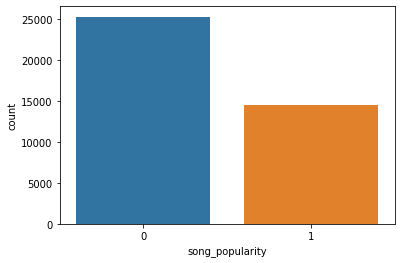

In [742]:
sns.countplot(data=df, x='song_popularity')

In [743]:
df.song_popularity.value_counts()

0    25312
1    14479
Name: song_popularity, dtype: int64

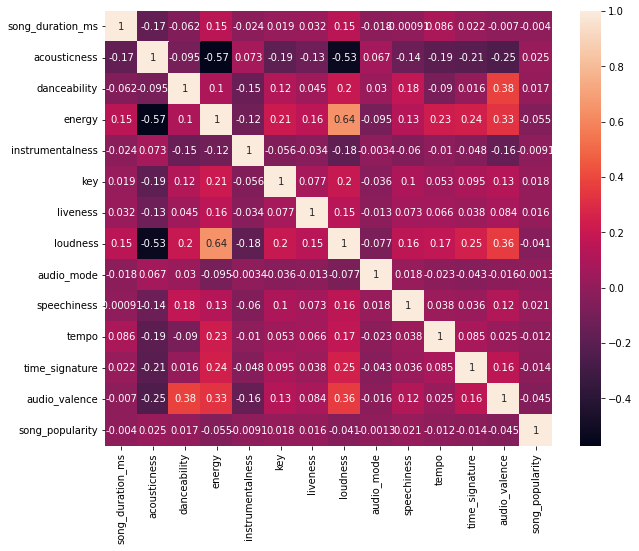

In [744]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)

In [745]:
counts = df.song_popularity.value_counts()
counts/counts.sum()

0    0.636124
1    0.363876
Name: song_popularity, dtype: float64

In [746]:
def resample(df, frac_1=1, frac_0=1):
  df_1 = df[df.song_popularity==1].sample(frac=frac_1, replace=False)
  df_0 = df[df.song_popularity==0].sample(frac=frac_0, replace=False)
  df = pd.concat([df_1, df_0]).sample(frac=1, replace=False)
  df.reset_index(inplace=True, drop=True)
  return df

In [747]:
train_df = resample(df, frac_0=1, frac_1=1)

In [748]:
train_df.song_popularity.value_counts()

0    25312
1    14479
Name: song_popularity, dtype: int64

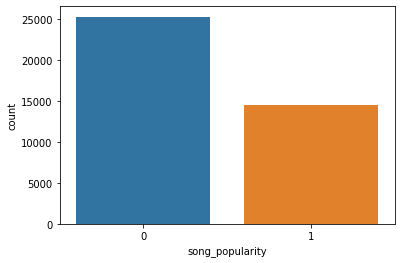

In [749]:
sns.countplot(data=train_df, x='song_popularity')

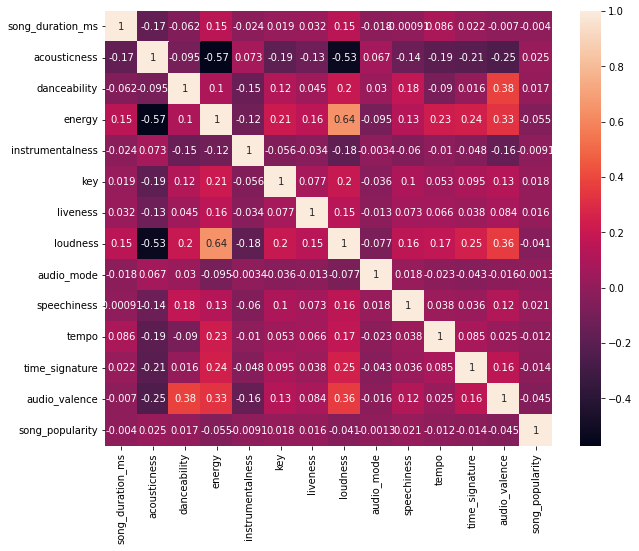

In [750]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), annot=True)

In [751]:
train_df.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,195639.0,0.085303,0.831931,0.577731,0.001352,1.0,0.126959,-4.543322,0,0.130554,124.484421,3,0.688739,1
1,192227.0,NaN,NaN,0.496310,-0.000366,8.0,0.131052,-6.797028,1,0.118583,90.764154,2,0.450645,1
2,NaN,0.022250,0.417151,0.653250,-0.000438,1.0,0.096609,-3.949671,0,0.205867,86.580838,3,0.424995,1
3,238967.0,0.021817,0.242913,0.352160,NaN,7.0,0.120755,-14.031147,0,0.047594,102.789240,3,0.293116,1
4,238537.0,0.183553,0.388268,0.307188,0.002476,4.0,0.135359,-10.385418,0,0.031702,116.504629,4,0.459493,0


In [752]:
train_df["log_ins"] = np.log(train_df.instrumentalness)
train_df.drop('instrumentalness', inplace=True, axis=1)

test_df["log_ins"] = np.log(test_df.instrumentalness)
test_df.drop('instrumentalness', inplace=True, axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


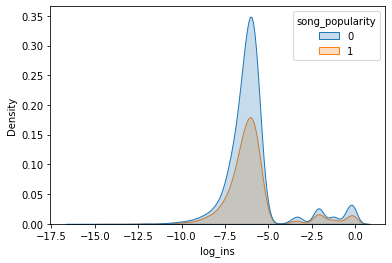

In [753]:
sns.kdeplot(data=train_df, x='log_ins', hue='song_popularity', fill=True)

Milliseconds to Minutes

In [754]:
train_df["song_duration_m"] = train_df.song_duration_ms.copy()/60000.
train_df.drop('song_duration_ms', inplace=True, axis=1)

test_df["song_duration_m"] = test_df.song_duration_ms.copy()/60000.
test_df.drop('song_duration_ms', inplace=True, axis=1)


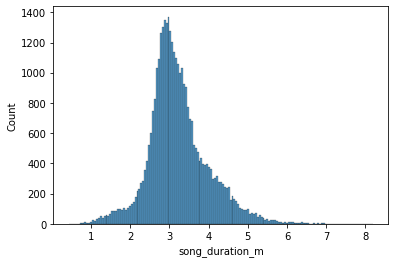

In [755]:
sns.histplot(data=train_df, x='song_duration_m')

Make splits

In [756]:
data = train_df.drop(labels='song_popularity', axis=1)
target = train_df['song_popularity']
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, stratify=target)

In [757]:
train = pd.concat([X_train, y_train], axis=1)

In [758]:
valid = pd.concat([X_valid, y_valid], axis=1)

In [759]:
valid.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity
30153,NaN,0.806153,0.815240,2.0,0.135767,-5.629497,1,0.050399,143.756960,3,0.753350,-5.516991,3.002300,0
20071,0.079342,0.842487,0.579820,10.0,0.102615,-7.994405,0,0.149740,94.998272,4,0.951112,-5.659638,2.504217,1
37304,NaN,NaN,0.687383,8.0,NaN,-4.742182,0,0.038253,106.486555,3,0.661293,-6.966546,2.871717,1
22684,0.021284,0.449611,0.944502,6.0,0.161359,-5.498508,1,0.042637,101.552223,4,0.555487,-6.489760,3.450600,0
36056,0.401394,0.736810,NaN,7.0,0.128625,-8.016616,1,0.072136,99.505918,3,0.370660,-5.752300,2.937650,1


In [760]:
has_nan = train.notna().sum(0) != train.shape[0]
has_nan

acousticness        True
danceability        True
energy              True
key                 True
liveness            True
loudness            True
audio_mode         False
speechiness        False
tempo              False
time_signature     False
audio_valence      False
log_ins             True
song_duration_m     True
song_popularity    False
dtype: bool

In [761]:
impute_cols = has_nan.index[has_nan].to_list()
impute_cols

['acousticness',
 'danceability',
 'energy',
 'key',
 'liveness',
 'loudness',
 'log_ins',
 'song_duration_m']

In [762]:
target_col = 'song_popularity'

# Trying out imputers

In [763]:
si = SimpleImputer()

In [764]:
ii = IterativeImputer(n_nearest_features=10)

In [765]:
kni = KNNImputer(n_neighbors=10)

In [639]:
for imputer in [si, ii, kni]:
  _data_ = train.drop(target_col, axis=1)
  _data_ = imputer.fit_transform(_data_)
  _target_ = train[target_col]
  cv_results = cross_validate(LogisticRegression(max_iter=50, solver='liblinear'), _data_, _target_, cv=4, 
                              scoring='roc_auc', return_train_score=True, return_estimator=True)
  print(f"{type(imputer)}, train: {cv_results['train_score'].mean()}, test: {cv_results['test_score'].mean()}")


<class 'sklearn.impute._base.SimpleImputer'>, train: 0.5549219051688827, test: 0.5512319282718203


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


<class 'sklearn.impute._iterative.IterativeImputer'>, train: 0.5563986968295022, test: 0.5532029146996597
<class 'sklearn.impute._knn.KNNImputer'>, train: 0.5558454112208636, test: 0.5520896825547176


Iterative imputer seems to work best.

In [766]:
x = train.copy()
v = valid.copy()
t = test_df.copy()
x[impute_cols] = ii.fit_transform(x[impute_cols]) # fit and transform the train data
v[impute_cols] = ii.transform(v[impute_cols]) # but only transform for test data

t[impute_cols] = ii.transform(t[impute_cols]) # but only transform for test data

# Discretize continuous columns to make categories

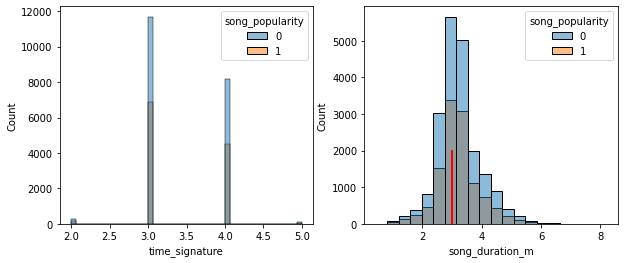

In [767]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=x, x='time_signature', hue=target_col)
plt.subplot(1,2,2)
sns.histplot(data=x, x='song_duration_m', hue=target_col, bins=20)
plt.plot([3, 3], [0, 2000], linewidth=2, color='red')

In [768]:
feature_cols = x.columns.to_list()
cat_cols = ['audio_mode', 'time_signature']
cont_cols = ['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness', 'audio_valence']

In [769]:
cont_2_cat = ['log_ins', 'key', 'tempo', 'song_duration_m', 'energy']

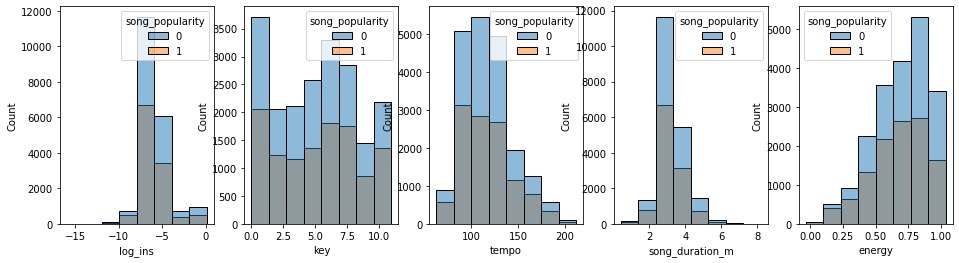

In [770]:
plt.figure(figsize=(16,4))
for i, col in enumerate(cont_2_cat):
  plt.subplot(1,5,i+1)
  sns.histplot(data=x, x=col, hue=target_col, bins=8)

Preserve continuous data

In [771]:
preserve_cols = ['log_ins', 'song_duration_m', 'tempo', 'energy']
preserve_cols_as = ['log_ins_cont', 'song_duration_m_cont', 'tempo_cont', 'energy_cont']
x[preserve_cols_as] = x[preserve_cols]
v[preserve_cols_as] = v[preserve_cols]
t[preserve_cols_as] = t[preserve_cols]

In [772]:
cont_cols += preserve_cols_as

In [773]:
feature_cols += preserve_cols_as

In [774]:
cont_cols

['acousticness',
 'danceability',
 'energy',
 'liveness',
 'loudness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont']

In [775]:
v.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont
30153,0.189149,0.806153,0.815240,2.0,0.135767,-5.629497,1,0.050399,143.756960,3,0.753350,-5.516991,3.002300,0,-5.516991,3.002300,143.756960,0.815240
20071,0.079342,0.842487,0.579820,10.0,0.102615,-7.994405,0,0.149740,94.998272,4,0.951112,-5.659638,2.504217,1,-5.659638,2.504217,94.998272,0.579820
37304,0.215032,0.641555,0.687383,8.0,0.215612,-4.742182,0,0.038253,106.486555,3,0.661293,-6.966546,2.871717,1,-6.966546,2.871717,106.486555,0.687383
22684,0.021284,0.449611,0.944502,6.0,0.161359,-5.498508,1,0.042637,101.552223,4,0.555487,-6.489760,3.450600,0,-6.489760,3.450600,101.552223,0.944502
36056,0.401394,0.736810,0.633134,7.0,0.128625,-8.016616,1,0.072136,99.505918,3,0.370660,-5.752300,2.937650,1,-5.752300,2.937650,99.505918,0.633134


In [776]:
kbd = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')

In [777]:
x_kbd = x.copy()
v_kbd = v.copy()
t_kbd = t.copy()
x_kbd[cont_2_cat] = kbd.fit_transform(x_kbd[cont_2_cat]) # fit and transform the train data
v_kbd[cont_2_cat] = kbd.transform(v_kbd[cont_2_cat]) # but only transform for valid data
t_kbd[cont_2_cat] = kbd.transform(t_kbd[cont_2_cat]) # but only transform for valid data

In [778]:
x_kbd.dtypes

acousticness            float64
danceability            float64
energy                  float64
key                     float64
liveness                float64
loudness                float64
audio_mode                int64
speechiness             float64
tempo                   float64
time_signature            int64
audio_valence           float64
log_ins                 float64
song_duration_m         float64
song_popularity           int64
log_ins_cont            float64
song_duration_m_cont    float64
tempo_cont              float64
energy_cont             float64
dtype: object

In [779]:
cat_cols += cont_2_cat

In [780]:
cat_cols

['audio_mode',
 'time_signature',
 'log_ins',
 'key',
 'tempo',
 'song_duration_m',
 'energy']

In [781]:
cont_cols

['acousticness',
 'danceability',
 'energy',
 'liveness',
 'loudness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont']

# New features
https://developer.spotify.com/discover/

Mood: Danceability, Valence, Energy, Tempo

Properties: Loudness, Speechiness, Instrumentalness

Context: Liveness, Acousticness

Segments, Tatums, Bars, Beats, Pitches, Timbre, and more

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

In [782]:
x_kbd["is_live"] = (x_kbd.liveness>=0.8).astype(int)
v_kbd["is_live"] = (v_kbd.liveness>=0.8).astype(int)
t_kbd["is_live"] = (t_kbd.liveness>=0.8).astype(int)

In [783]:
cat_cols.append("is_live")
feature_cols.append("is_live")

In [784]:
x_kbd.is_live.sum(), v_kbd.is_live.sum(), t_kbd.is_live.sum()

(160, 33, 47)

In [785]:
kbd_2 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

In [786]:
x_kbd['speechiness_level'] = kbd_2.fit_transform(x_kbd['speechiness'].values.reshape(-1,1))
v_kbd['speechiness_level'] = kbd_2.transform(v_kbd['speechiness'].values.reshape(-1,1))
t_kbd['speechiness_level'] = kbd_2.transform(t_kbd['speechiness'].values.reshape(-1,1))

In [787]:
cat_cols.append("speechiness_level")
feature_cols.append("speechiness_level")

In [788]:
x_kbd['valence'] = kbd_2.fit_transform(x_kbd['audio_valence'].values.reshape(-1,1))
v_kbd['valence'] = kbd_2.transform(v_kbd['audio_valence'].values.reshape(-1,1))
t_kbd['valence'] = kbd_2.transform(t_kbd['audio_valence'].values.reshape(-1,1))

In [789]:
cat_cols.append("valence")
feature_cols.append("valence")

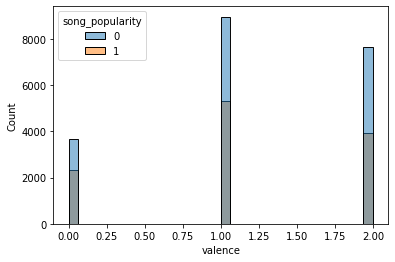

In [790]:
sns.histplot(data=x_kbd, x='valence', hue=target_col)

In [791]:
# https://music.stackexchange.com/questions/90286/how-long-is-a-bar
x_kbd['bpm'] = (60./x_kbd.time_signature)*4
v_kbd['bpm'] = (60./v_kbd.time_signature)*4
t_kbd['bpm'] = (60./t_kbd.time_signature)*4

In [792]:
cat_cols.append("bpm")
feature_cols.append("bpm")

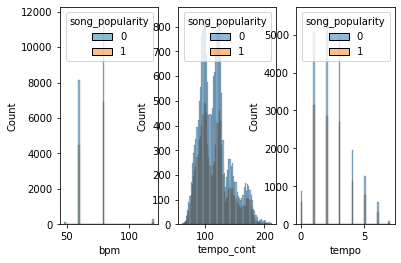

In [793]:
plt.subplot(1,3,1)
sns.histplot(data=x_kbd, x='bpm', hue=target_col)
plt.subplot(1,3,2)
sns.histplot(data=x_kbd, x='tempo_cont', hue=target_col)
plt.subplot(1,3,3)
sns.histplot(data=x_kbd, x='tempo', hue=target_col)

In [794]:
x_kbd.bpm.min()

48.0

In [795]:
x_kbd["f1"] = (x_kbd.audio_valence*x_kbd.loudness)
v_kbd["f1"] = (v_kbd.audio_valence*v_kbd.loudness)
t_kbd["f1"] = (t_kbd.audio_valence*t_kbd.loudness)

In [796]:
x_kbd["f2"] = 1/np.exp(x_kbd.audio_valence)
v_kbd["f2"] = 1/np.exp(v_kbd.audio_valence)
t_kbd["f2"] = 1/np.exp(t_kbd.audio_valence)

In [797]:
x_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2
38754,0.171518,0.771586,3.0,2.0,0.090668,-13.023834,1,0.374589,1.0,3,0.338582,5.0,2.0,1,-5.685862,3.028645,91.458484,0.471950,0,2.0,0.0,80.0,-4.409630,0.712781
33824,0.020867,0.425238,5.0,1.0,0.125137,-15.579105,1,0.045951,4.0,3,0.685437,6.0,2.0,1,-3.076899,2.745100,145.361921,0.684844,0,0.0,1.0,80.0,-10.678496,0.503870
32647,0.077024,0.683368,6.0,4.0,0.113637,-3.762734,0,0.043470,2.0,3,0.395992,4.0,2.0,0,-5.954191,3.096150,117.701192,0.818191,0,0.0,1.0,80.0,-1.490012,0.673012
20775,0.519481,0.313605,3.0,0.0,0.104981,-12.272236,1,0.059042,3.0,3,0.474223,5.0,2.0,1,-5.676054,2.749583,127.352201,0.487660,0,0.0,1.0,80.0,-5.819774,0.622369
3939,0.638099,0.693150,5.0,7.0,0.083411,-9.002265,1,0.121997,1.0,4,0.440677,4.0,2.0,1,-6.645917,3.218800,91.189889,0.665274,0,0.0,1.0,60.0,-3.967095,0.643600


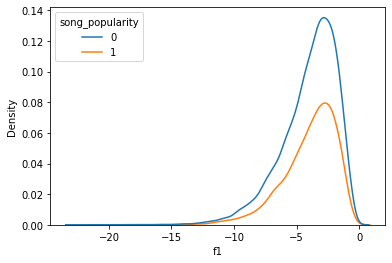

In [798]:
sns.kdeplot(data=x_kbd, x="f1", hue="song_popularity")

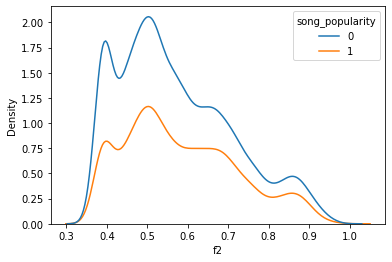

In [799]:
sns.kdeplot(data=x_kbd, x="f2", hue="song_popularity")

In [800]:
cont_cols

['acousticness',
 'danceability',
 'energy',
 'liveness',
 'loudness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont']

In [801]:
cont_cols += ["f1", "f2"]

In [802]:
feature_cols += ["f1", "f2"]
feature_cols

['acousticness',
 'danceability',
 'energy',
 'key',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence',
 'log_ins',
 'song_duration_m',
 'song_popularity',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 'is_live',
 'speechiness_level',
 'valence',
 'bpm',
 'f1',
 'f2']

# Cluster distance as a feature

Read that year is a good feature, so assuming 100 years of data, take that as 10 centuries

In [803]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=1)

In [804]:
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]
# gives distance to cluster center for each sample # to get cluster as number, do predict
# since this is a fit transform and not a fit predict
x_cd = kmeans.fit_transform(x_kbd[cont_cols])
x_cd = pd.DataFrame(x_cd, columns=cluster_cols, index=x_kbd.index)
x_kbd = pd.concat([x_kbd,x_cd], axis=1)

In [805]:
x_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
38754,0.171518,0.771586,3.0,2.0,0.090668,-13.023834,1,0.374589,1.0,3,0.338582,5.0,2.0,1,-5.685862,3.028645,91.458484,0.471950,0,2.0,0.0,80.0,-4.409630,0.712781,62.290936,7.654356,34.943248,96.289805,12.042692,79.522689,25.930173,13.735826,1.798989,49.682087
33824,0.020867,0.425238,5.0,1.0,0.125137,-15.579105,1,0.045951,4.0,3,0.685437,6.0,2.0,1,-3.076899,2.745100,145.361921,0.684844,0,0.0,1.0,80.0,-10.678496,0.503870,12.918466,52.411175,22.646947,43.864932,65.958697,28.132706,31.883501,43.212053,53.934877,11.865607
32647,0.077024,0.683368,6.0,4.0,0.113637,-3.762734,0,0.043470,2.0,3,0.395992,4.0,2.0,0,-5.954191,3.096150,117.701192,0.818191,0,0.0,1.0,80.0,-1.490012,0.673012,36.311843,23.629041,9.063719,69.840801,38.188354,53.024803,3.240642,14.706241,28.375160,23.516538
20775,0.519481,0.313605,3.0,0.0,0.104981,-12.272236,1,0.059042,3.0,3,0.474223,5.0,2.0,1,-5.676054,2.749583,127.352201,0.487660,0,0.0,1.0,80.0,-5.819774,0.622369,26.574678,33.679147,6.307201,60.533701,47.406720,43.863671,13.601788,24.433585,35.620082,14.548023
3939,0.638099,0.693150,5.0,7.0,0.083411,-9.002265,1,0.121997,1.0,4,0.440677,4.0,2.0,1,-6.645917,3.218800,91.189889,0.665274,0,0.0,1.0,60.0,-3.967095,0.643600,62.383318,4.217051,34.672571,96.330184,11.227924,79.504529,25.182231,12.625104,6.058414,49.614881


In [806]:
x_cd = kmeans.transform(v_kbd[cont_cols]) # dont fit for test
x_cd = pd.DataFrame(x_cd, columns=cluster_cols, index=v_kbd.index)
v_kbd = pd.concat([v_kbd,x_cd], axis=1)
v_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
30153,0.189149,0.806153,6.0,1.0,0.135767,-5.629497,1,0.050399,4.0,3,0.753350,5.0,2.0,0,-5.516991,3.002300,143.756960,0.815240,0,0.0,2.0,80.0,-4.240982,0.470787,10.333799,49.436232,18.049687,43.746733,63.818396,26.919314,27.667553,40.160336,52.770792,3.642590
20071,0.079342,0.842487,4.0,7.0,0.102615,-7.994405,0,0.149740,1.0,4,0.951112,5.0,2.0,1,-5.659638,2.504217,94.998272,0.579820,0,1.0,2.0,60.0,-7.603571,0.386311,58.663539,4.490733,31.074022,92.623363,15.349786,75.807783,21.709472,9.496824,7.531903,45.922894
37304,0.215032,0.641555,5.0,5.0,0.215612,-4.742182,0,0.038253,2.0,3,0.661293,4.0,2.0,1,-6.966546,2.871717,106.486555,0.687383,0,0.0,1.0,80.0,-3.135970,0.516184,47.251759,12.289457,19.473266,81.017462,26.874712,64.177167,9.737201,3.867967,17.845832,34.409068
22684,0.021284,0.449611,7.0,4.0,0.161359,-5.498508,1,0.042637,2.0,4,0.555487,4.0,3.0,0,-6.489760,3.450600,101.552223,0.944502,0,0.0,1.0,60.0,-3.054352,0.573793,52.177251,7.577074,24.375986,85.939088,22.080947,69.105513,14.629021,3.520291,14.000297,39.334675
36056,0.401394,0.736810,5.0,5.0,0.128625,-8.016616,1,0.072136,1.0,3,0.370660,5.0,2.0,1,-5.752300,2.937650,99.505918,0.633134,0,0.0,1.0,80.0,-2.971438,0.690279,54.078761,5.536958,26.329486,87.985873,19.548899,71.159199,16.827478,4.433326,10.396035,41.288507


In [807]:
x_cd = kmeans.transform(t_kbd[cont_cols]) # dont fit for test
x_cd = pd.DataFrame(x_cd, columns=cluster_cols, index=t_kbd.index)
t_kbd = pd.concat([t_kbd,x_cd], axis=1)
t_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.019845,0.501230,7.0,3.0,0.112832,-8.890172,0,0.082714,3.0,4,0.399620,4.0,4.0,-6.544156,5.142050,126.129304,0.908939,0,0.0,1.0,60.0,-3.552694,0.670575,27.649298,32.015641,3.373049,61.438657,46.221957,44.651881,10.837090,22.749756,35.144574,15.025581
1,0.070119,0.731256,3.0,7.0,0.139040,-6.301214,0,0.061685,1.0,3,0.499424,4.0,2.0,-6.204810,3.333517,86.448149,0.444655,0,0.0,1.0,80.0,-3.146980,0.606880,67.174826,8.173560,39.415797,101.060749,7.210599,84.227168,29.801900,17.344971,9.862288,54.373381
2,0.810637,0.568858,1.0,0.0,0.226614,-11.542478,0,0.041868,1.0,3,0.564951,7.0,4.0,-0.106649,4.662633,99.544351,0.125466,0,0.0,1.0,80.0,-6.520930,0.568388,54.590596,10.842973,27.777777,88.462112,20.750667,71.775911,19.501968,9.901096,9.894449,42.128854
3,0.332922,0.871789,4.0,2.0,0.325391,-7.905546,1,0.046815,3.0,4,0.906485,4.0,3.0,-7.243249,4.153283,123.063854,0.557342,0,0.0,2.0,60.0,-7.166262,0.403941,30.684839,29.020531,4.802155,64.605068,43.147196,47.812046,8.484492,19.763463,32.085858,18.067148
4,0.765568,0.624687,5.0,5.0,0.308284,-7.683531,0,0.129284,1.0,3,0.935571,3.0,2.0,-7.967652,3.078807,88.703121,0.710794,0,0.0,2.0,80.0,-7.188492,0.392362,64.963313,7.013264,37.302402,98.896715,9.592679,82.068168,27.796333,15.398375,8.367389,52.197778


In [808]:
feature_cols += cluster_cols

In [809]:
cont_cols += cluster_cols

In [810]:
cont_cols

['acousticness',
 'danceability',
 'energy',
 'liveness',
 'loudness',
 'speechiness',
 'audio_valence',
 'log_ins_cont',
 'song_duration_m_cont',
 'tempo_cont',
 'energy_cont',
 'f1',
 'f2',
 'cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6',
 'cluster7',
 'cluster8',
 'cluster9',
 'cluster10']

# Cluster as number

In [811]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=1)

In [812]:
cluster_col = ['year_cluster']
kmeans.fit(x_kbd[cont_cols])
x_c = kmeans.predict(x_kbd[cont_cols])

In [813]:
x_c = pd.DataFrame(x_c, columns=cluster_col, index=x_kbd.index)

In [814]:
x_kbd = pd.concat([x_kbd,x_c], axis=1)

In [815]:
x_kbd.notna().sum()

acousticness            31832
danceability            31832
energy                  31832
key                     31832
liveness                31832
loudness                31832
audio_mode              31832
speechiness             31832
tempo                   31832
time_signature          31832
audio_valence           31832
log_ins                 31832
song_duration_m         31832
song_popularity         31832
log_ins_cont            31832
song_duration_m_cont    31832
tempo_cont              31832
energy_cont             31832
is_live                 31832
speechiness_level       31832
valence                 31832
bpm                     31832
f1                      31832
f2                      31832
cluster1                31832
cluster2                31832
cluster3                31832
cluster4                31832
cluster5                31832
cluster6                31832
cluster7                31832
cluster8                31832
cluster9                31832
cluster10 

In [816]:
x_c = kmeans.predict(v_kbd[cont_cols])
x_c = pd.DataFrame(x_c, columns=cluster_col, index=v_kbd.index)
v_kbd = pd.concat([v_kbd,x_c], axis=1)
v_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,song_popularity,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,year_cluster
30153,0.189149,0.806153,6.0,1.0,0.135767,-5.629497,1,0.050399,4.0,3,0.753350,5.0,2.0,0,-5.516991,3.002300,143.756960,0.815240,0,0.0,2.0,80.0,-4.240982,0.470787,10.333799,49.436232,18.049687,43.746733,63.818396,26.919314,27.667553,40.160336,52.770792,3.642590,7
20071,0.079342,0.842487,4.0,7.0,0.102615,-7.994405,0,0.149740,1.0,4,0.951112,5.0,2.0,1,-5.659638,2.504217,94.998272,0.579820,0,1.0,2.0,60.0,-7.603571,0.386311,58.663539,4.490733,31.074022,92.623363,15.349786,75.807783,21.709472,9.496824,7.531903,45.922894,0
37304,0.215032,0.641555,5.0,5.0,0.215612,-4.742182,0,0.038253,2.0,3,0.661293,4.0,2.0,1,-6.966546,2.871717,106.486555,0.687383,0,0.0,1.0,80.0,-3.135970,0.516184,47.251759,12.289457,19.473266,81.017462,26.874712,64.177167,9.737201,3.867967,17.845832,34.409068,5
22684,0.021284,0.449611,7.0,4.0,0.161359,-5.498508,1,0.042637,2.0,4,0.555487,4.0,3.0,0,-6.489760,3.450600,101.552223,0.944502,0,0.0,1.0,60.0,-3.054352,0.573793,52.177251,7.577074,24.375986,85.939088,22.080947,69.105513,14.629021,3.520291,14.000297,39.334675,0
36056,0.401394,0.736810,5.0,5.0,0.128625,-8.016616,1,0.072136,1.0,3,0.370660,5.0,2.0,1,-5.752300,2.937650,99.505918,0.633134,0,0.0,1.0,80.0,-2.971438,0.690279,54.078761,5.536958,26.329486,87.985873,19.548899,71.159199,16.827478,4.433326,10.396035,41.288507,0


In [817]:
x_c = kmeans.predict(t_kbd[cont_cols])
x_c = pd.DataFrame(x_c, columns=cluster_col, index=t_kbd.index)
t_kbd = pd.concat([t_kbd,x_c], axis=1)
t_kbd.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,year_cluster
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.019845,0.501230,7.0,3.0,0.112832,-8.890172,0,0.082714,3.0,4,0.399620,4.0,4.0,-6.544156,5.142050,126.129304,0.908939,0,0.0,1.0,60.0,-3.552694,0.670575,27.649298,32.015641,3.373049,61.438657,46.221957,44.651881,10.837090,22.749756,35.144574,15.025581,2
1,0.070119,0.731256,3.0,7.0,0.139040,-6.301214,0,0.061685,1.0,3,0.499424,4.0,2.0,-6.204810,3.333517,86.448149,0.444655,0,0.0,1.0,80.0,-3.146980,0.606880,67.174826,8.173560,39.415797,101.060749,7.210599,84.227168,29.801900,17.344971,9.862288,54.373381,4
2,0.810637,0.568858,1.0,0.0,0.226614,-11.542478,0,0.041868,1.0,3,0.564951,7.0,4.0,-0.106649,4.662633,99.544351,0.125466,0,0.0,1.0,80.0,-6.520930,0.568388,54.590596,10.842973,27.777777,88.462112,20.750667,71.775911,19.501968,9.901096,9.894449,42.128854,0
3,0.332922,0.871789,4.0,2.0,0.325391,-7.905546,1,0.046815,3.0,4,0.906485,4.0,3.0,-7.243249,4.153283,123.063854,0.557342,0,0.0,2.0,60.0,-7.166262,0.403941,30.684839,29.020531,4.802155,64.605068,43.147196,47.812046,8.484492,19.763463,32.085858,18.067148,2
4,0.765568,0.624687,5.0,5.0,0.308284,-7.683531,0,0.129284,1.0,3,0.935571,3.0,2.0,-7.967652,3.078807,88.703121,0.710794,0,0.0,2.0,80.0,-7.188492,0.392362,64.963313,7.013264,37.302402,98.896715,9.592679,82.068168,27.796333,15.398375,8.367389,52.197778,4


In [818]:
cat_cols += cluster_col

In [819]:
feature_cols += cluster_col

In [820]:
cat_cols

['audio_mode',
 'time_signature',
 'log_ins',
 'key',
 'tempo',
 'song_duration_m',
 'energy',
 'is_live',
 'speechiness_level',
 'valence',
 'bpm',
 'year_cluster']

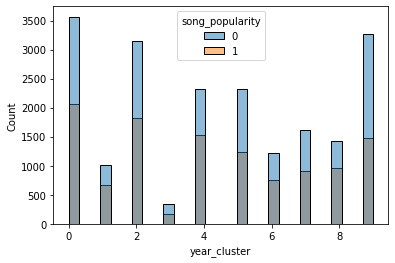

In [821]:
sns.histplot(data=x_kbd, x="year_cluster", hue="song_popularity")

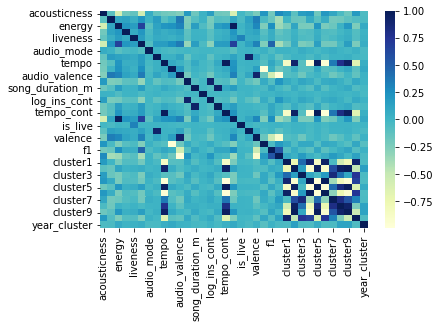

In [822]:
sns.heatmap(x_kbd.corr(), cmap="YlGnBu")

In [823]:
cat_cols

['audio_mode',
 'time_signature',
 'log_ins',
 'key',
 'tempo',
 'song_duration_m',
 'energy',
 'is_live',
 'speechiness_level',
 'valence',
 'bpm',
 'year_cluster']

In [824]:
for c in cat_cols:
  x_kbd[c] = x_kbd[c].astype('int').astype('category')
  v_kbd[c] = v_kbd[c].astype('int').astype('category')
  t_kbd[c] = t_kbd[c].astype('int').astype('category')

# Make Pipeline

In [825]:
x_kbd.columns

Index(['acousticness', 'danceability', 'energy', 'key', 'liveness', 'loudness',
       'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'log_ins', 'song_duration_m', 'song_popularity', 'log_ins_cont',
       'song_duration_m_cont', 'tempo_cont', 'energy_cont', 'is_live',
       'speechiness_level', 'valence', 'bpm', 'f1', 'f2', 'cluster1',
       'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7',
       'cluster8', 'cluster9', 'cluster10', 'year_cluster'],
      dtype='object')

In [826]:
ct = make_column_transformer(
    (StandardScaler(), cont_cols),
    remainder='passthrough')

In [827]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'energy',
                                  'liveness', 'loudness', 'speechiness',
                                  'audio_valence', 'log_ins_cont',
                                  'song_duration_m_cont', 'tempo_cont',
                                  'energy_cont', 'f1', 'f2', 'cluster1',
                                  'cluster2', 'cluster3', 'cluster4',
                                  'cluster5', 'cluster6', 'cluster7',
                                  'cluster8', 'cluster9', 'cluster10'])])

In [828]:
data = x_kbd.drop(labels=target_col, axis=1)
target = x_kbd.song_popularity
v_data = v_kbd.drop(labels=target_col, axis=1)
v_target = v_kbd.song_popularity

In [829]:
t_data = t_kbd

In [830]:
data.shape, v_data.shape, t_data.shape

((31832, 34), (7959, 34), (10000, 34))

In [831]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['acousticness', 'danceability', 'energy',
                                  'liveness', 'loudness', 'speechiness',
                                  'audio_valence', 'log_ins_cont',
                                  'song_duration_m_cont', 'tempo_cont',
                                  'energy_cont', 'f1', 'f2', 'cluster1',
                                  'cluster2', 'cluster3', 'cluster4',
                                  'cluster5', 'cluster6', 'cluster7',
                                  'cluster8', 'cluster9', 'cluster10'])])

In [832]:
data.shape, len(cont_cols), len(cat_cols)

((31832, 34), 23, 12)

In [833]:
data.key.value_counts()

0    5769
4    5104
5    4601
3    3947
7    3541
1    3303
2    3271
6    2296
Name: key, dtype: int64

In [834]:
cat_col_id = [i for i, col_name in enumerate(data.columns) if col_name in cat_cols]

In [835]:
cat_col_id

[2, 3, 6, 8, 9, 11, 12, 17, 18, 19, 20, 33]

In [836]:
model_hgb = make_pipeline(ct, HistGradientBoostingClassifier(scoring='roc_auc'))

In [837]:
data

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,year_cluster
38754,0.171518,0.771586,3,2,0.090668,-13.023834,1,0.374589,1,3,0.338582,5,2,-5.685862,3.028645,91.458484,0.471950,0,2,0,80,-4.409630,0.712781,62.290936,7.654356,34.943248,96.289805,12.042692,79.522689,25.930173,13.735826,1.798989,49.682087,4
33824,0.020867,0.425238,5,1,0.125137,-15.579105,1,0.045951,4,3,0.685437,6,2,-3.076899,2.745100,145.361921,0.684844,0,0,1,80,-10.678496,0.503870,12.918466,52.411175,22.646947,43.864932,65.958697,28.132706,31.883501,43.212053,53.934877,11.865607,7
32647,0.077024,0.683368,6,4,0.113637,-3.762734,0,0.043470,2,3,0.395992,4,2,-5.954191,3.096150,117.701192,0.818191,0,0,1,80,-1.490012,0.673012,36.311843,23.629041,9.063719,69.840801,38.188354,53.024803,3.240642,14.706241,28.375160,23.516538,9
20775,0.519481,0.313605,3,0,0.104981,-12.272236,1,0.059042,3,3,0.474223,5,2,-5.676054,2.749583,127.352201,0.487660,0,0,1,80,-5.819774,0.622369,26.574678,33.679147,6.307201,60.533701,47.406720,43.863671,13.601788,24.433585,35.620082,14.548023,2
3939,0.638099,0.693150,5,7,0.083411,-9.002265,1,0.121997,1,4,0.440677,4,2,-6.645917,3.218800,91.189889,0.665274,0,0,1,60,-3.967095,0.643600,62.383318,4.217051,34.672571,96.330184,11.227924,79.504529,25.182231,12.625104,6.058414,49.614881,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,0.010578,0.115379,6,4,0.079407,-4.426479,1,0.076734,5,4,0.413834,5,3,-5.578360,4.189817,172.358588,0.865978,0,0,1,60,-1.831829,0.661110,19.487136,78.077758,46.701744,15.316773,92.473298,3.087720,56.307621,68.820720,81.299541,31.846907,6
33018,0.386938,0.843396,5,5,0.109416,-7.055798,1,0.045598,4,3,0.753327,4,2,-6.371021,3.067840,141.341437,0.660863,0,0,2,80,-5.315322,0.470798,12.363486,47.031666,15.627698,46.206696,61.326620,29.391416,25.353217,37.721150,50.125053,1.439871,7
8442,0.120464,0.724195,7,1,0.117277,-4.754668,1,0.173324,3,4,0.548428,4,2,-6.425234,2.979650,122.384144,0.928880,0,1,1,60,-2.607593,0.577858,31.554055,28.182217,4.674904,65.130962,42.702101,48.304824,6.547999,19.054913,32.426812,18.752395,2
34448,0.060739,0.655377,4,7,0.119043,-7.104308,1,0.174999,2,3,0.740933,4,2,-5.986103,3.135317,100.786680,0.612398,0,1,2,80,-5.263814,0.476669,52.802268,6.748247,25.072537,86.734875,20.847686,69.902083,15.586364,3.256370,11.568084,40.008270,0


In [838]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Search for HGB

In [839]:
model_hgb.fit(data,target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'liveness', 'loudness',
                                                   'speechiness',
                                                   'audio_valence',
                                                   'log_ins_cont',
                                                   'song_duration_m_cont',
                                                   'tempo_cont', 'energy_cont',
                                                   'f1', 'f2', 'cluster1',
                                                   'cluster2', 'cluster3',
                                                   'cluster4', 'cluster5',
                                                   'cluster6', 'cluster7',
                                                   'cluster8', 'cluster9',
                                                   'cluster10'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(scoring='roc_auc'))])

In [840]:
model_hgb.score(data, target), model_hgb.score(v_data, v_target)

(0.637880120633325, 0.6357582610880764)

In [841]:
param_distrib_hgb = {
    'histgradientboostingclassifier__l2_regularization': lognorm(1),
    'histgradientboostingclassifier__learning_rate': lognorm(1),
    'histgradientboostingclassifier__max_depth': [x for x in range(10,300,10)],
    'histgradientboostingclassifier__max_iter': [x for x in range(5,200,20)],
    'histgradientboostingclassifier__max_bins' : [x for x in range(len(cat_col_id),255,10)],
}

In [842]:
search_hgb = RandomizedSearchCV(model_hgb, param_distributions=param_distrib_hgb, 
                                scoring='roc_auc', n_jobs=4, cv=cv, n_iter=100)

In [843]:
search_hgb_results = search_hgb.fit(data, target)

In [844]:
search_hgb_results.best_estimator_.score(data, target), search_hgb_results.best_estimator_.score(v_data, v_target)

(0.639545111837145, 0.6351300414624953)

In [845]:
df_hgb = pd.DataFrame.from_records(search_hgb_results.cv_results_)
df_hgb.columns = [name.split('__')[-1] for name in df_hgb.columns]
df_hgb = df_hgb[[name for name in df_hgb.columns if 'time' not in name]]
df_hgb = df_hgb.sort_values(by='rank_test_score').head(10)
df_hgb

,mean_test_score,l2_regularization,learning_rate,max_bins,max_depth,max_iter,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score
81,0.564613,8.23313,0.199865,52,50,25,{'histgradientboostingclassifier__l2_regulariz...,1,0.566619,0.559833,0.571730,0.567410,0.557474,0.005221
91,0.561939,2.84467,0.0737165,172,90,185,{'histgradientboostingclassifier__l2_regulariz...,2,0.562544,0.549860,0.573857,0.567956,0.555480,0.008558
44,0.560275,2.22283,0.390886,212,110,5,{'histgradientboostingclassifier__l2_regulariz...,3,0.559686,0.553414,0.570924,0.560771,0.556582,0.005911
97,0.559832,2.33514,0.324659,152,80,105,{'histgradientboostingclassifier__l2_regulariz...,4,0.565687,0.551682,0.570184,0.565269,0.546338,0.009160
21,0.557590,1.01436,0.183473,192,180,165,{'histgradientboostingclassifier__l2_regulariz...,5,0.554070,0.551635,0.568092,0.566245,0.547905,0.008085
47,0.557450,5.18935,0.256684,62,90,65,{'histgradientboostingclassifier__l2_regulariz...,6,0.551820,0.551560,0.568787,0.568574,0.546508,0.009364
85,0.557128,0.418202,0.256494,182,200,185,{'histgradientboostingclassifier__l2_regulariz...,7,0.554378,0.549819,0.570831,0.555130,0.555480,0.007148
99,0.556809,1.10264,0.61846,72,290,5,{'histgradientboostingclassifier__l2_regulariz...,8,0.553907,0.549356,0.558626,0.566072,0.556082,0.005543
39,0.556245,0.947475,0.396128,22,10,5,{'histgradientboostingclassifier__l2_regulariz...,9,0.547509,0.550292,0.572003,0.548606,0.562814,0.009608
51,0.555381,0.788724,0.432466,32,20,125,{'histgradientboostingclassifier__l2_regulariz...,10,0.553252,0.550544,0.566584,0.554790,0.551736,0.005781


In [847]:
best_hgb = search_hgb_results.best_estimator_

# Search for LR

In [160]:
model_lr = make_pipeline(ct, LogisticRegression(solver='liblinear'))

In [161]:
model_lr.fit(data,target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'liveness', 'loudness',
                                                   'speechiness',
                                                   'audio_valence',
                                                   'log_ins_cont',
                                                   'song_duration_m_cont', 'f1',
                                                   'f2', 'f3', 'f4', 'cluster1',
                                                   'cluster2', 'cluster3',
                                                   'cluster4', 'cluster5'])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [162]:
model_lr.score(data, target), model_lr.score(v_data, v_target)

(0.6359952249308871, 0.6356326171629602)

In [163]:
param_distrib_lr = {
    'logisticregression__C': lognorm(1),
    'logisticregression__l1_ratio': lognorm(1),
    'logisticregression__warm_start': [True, False],
}

In [164]:
search_lr = RandomizedSearchCV(model_lr, param_distributions=param_distrib_lr, 
                                scoring='roc_auc', n_jobs=4, cv=cv, n_iter=100)

In [165]:
search_lr_results = search_lr.fit(data, target)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


In [166]:
search_lr_results.best_estimator_.score(data, target), search_lr_results.best_estimator_.score(v_data, v_target)

(0.6358695652173914, 0.6356326171629602)

In [167]:
df_lr = pd.DataFrame.from_records(search_lr_results.cv_results_)
df_lr.columns = [name.split('__')[-1] for name in df_lr.columns]
df_lr = df_lr[[name for name in df_lr.columns if 'time' not in name]]
df_lr = df_lr.sort_values(by='rank_test_score').head(10)
df_lr

,mean_test_score,C,l1_ratio,warm_start,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score
53,0.556222,0.993289,0.456388,False,"{'logisticregression__C': 0.9932889846659644, ...",1,0.554360,0.549996,0.573385,0.552266,0.551105,0.008702
67,0.556211,0.986991,1.76174,False,"{'logisticregression__C': 0.9869909291296505, ...",2,0.554348,0.549969,0.573354,0.552282,0.551102,0.008693
0,0.556210,1.00387,1.63815,True,"{'logisticregression__C': 1.0038663110994894, ...",3,0.554240,0.549996,0.573362,0.552337,0.551113,0.008691
19,0.556210,0.901008,0.437212,True,"{'logisticregression__C': 0.9010078482326419, ...",4,0.554270,0.550014,0.573319,0.552352,0.551093,0.008671
16,0.556204,1.0027,0.414319,True,"{'logisticregression__C': 1.0026991954389837, ...",5,0.554355,0.549963,0.573355,0.552334,0.551010,0.008700
92,0.556203,0.890584,1.89857,False,"{'logisticregression__C': 0.8905840933251725, ...",6,0.554272,0.549968,0.573324,0.552358,0.551092,0.008679
17,0.556196,0.930979,2.85369,False,"{'logisticregression__C': 0.9309793446912272, ...",7,0.554280,0.549953,0.573343,0.552344,0.551058,0.008694
47,0.556194,0.983254,1.3249,True,"{'logisticregression__C': 0.9832540505996691, ...",8,0.554235,0.549990,0.573346,0.552280,0.551118,0.008690
40,0.556193,0.92951,2.03111,True,"{'logisticregression__C': 0.9295103266598861, ...",9,0.554282,0.549954,0.573354,0.552341,0.551036,0.008700
48,0.556192,0.803213,1.14537,True,"{'logisticregression__C': 0.803212900219727, '...",10,0.554333,0.549924,0.573245,0.552394,0.551062,0.008652


In [168]:
best_lr = search_lr_results.best_estimator_

# Search RF

In [178]:
model_rf = make_pipeline(ct, RandomForestClassifier(n_estimators=50, max_depth=20))

In [179]:
model_rf.fit(data,target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'liveness', 'loudness',
                                                   'speechiness',
                                                   'audio_valence',
                                                   'log_ins_cont',
                                                   'song_duration_m_cont', 'f1',
                                                   'f2', 'f3', 'f4', 'cluster1',
                                                   'cluster2', 'cluster3',
                                                   'cluster4', 'cluster5'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_estimators=50,
                                        oob_score=True))])

In [180]:
model_rf.score(data, target), model_rf.score(v_data, v_target)

(0.9714752450364413, 0.6257067470787787)

In [181]:
param_distrib_rf = {
 'randomforestclassifier__ccp_alpha': lognorm(1),
 'randomforestclassifier__max_depth': [x for x in range(2,80,10)],
 'randomforestclassifier__n_estimators': [x for x in range(2,50,5)],
 'randomforestclassifier__warm_start': [True, False],
}

In [182]:
search_rf = RandomizedSearchCV(model_rf, param_distributions=param_distrib_rf, 
                                scoring='roc_auc', n_jobs=4, cv=cv, n_iter=100)

In [183]:
search_rf_results = search_rf.fit(data, target)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


In [184]:
search_rf_results.best_estimator_.score(data, target), search_rf_results.best_estimator_.score(v_data, v_target)

(0.636120884644383, 0.636135192863425)

In [185]:
df_rf = pd.DataFrame.from_records(search_rf_results.cv_results_)
df_rf.columns = [name.split('__')[-1] for name in df_rf.columns]
df_rf = df_rf[[name for name in df_rf.columns if 'time' not in name]]
df_rf = df_rf.sort_values(by='rank_test_score').head(10)
df_rf

,mean_test_score,ccp_alpha,max_depth,n_estimators,warm_start,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score
0,0.5,0.468059,42,7,True,{'randomforestclassifier__ccp_alpha': 0.468058...,1,0.5,0.5,0.5,0.5,0.5,0.0
72,0.5,1.57147,12,2,True,{'randomforestclassifier__ccp_alpha': 1.571467...,1,0.5,0.5,0.5,0.5,0.5,0.0
71,0.5,1.7152,32,42,True,{'randomforestclassifier__ccp_alpha': 1.715199...,1,0.5,0.5,0.5,0.5,0.5,0.0
70,0.5,7.16139,72,17,True,{'randomforestclassifier__ccp_alpha': 7.161385...,1,0.5,0.5,0.5,0.5,0.5,0.0
69,0.5,1.46066,22,2,True,{'randomforestclassifier__ccp_alpha': 1.460663...,1,0.5,0.5,0.5,0.5,0.5,0.0
68,0.5,1.11114,62,27,False,{'randomforestclassifier__ccp_alpha': 1.111143...,1,0.5,0.5,0.5,0.5,0.5,0.0
67,0.5,1.96568,42,32,False,{'randomforestclassifier__ccp_alpha': 1.965680...,1,0.5,0.5,0.5,0.5,0.5,0.0
66,0.5,2.02177,12,12,False,{'randomforestclassifier__ccp_alpha': 2.021774...,1,0.5,0.5,0.5,0.5,0.5,0.0
65,0.5,1.80304,62,27,True,{'randomforestclassifier__ccp_alpha': 1.803035...,1,0.5,0.5,0.5,0.5,0.5,0.0
64,0.5,3.10441,72,32,True,{'randomforestclassifier__ccp_alpha': 3.104413...,1,0.5,0.5,0.5,0.5,0.5,0.0


In [186]:
best_rf = search_rf_results.best_estimator_

# Retrain on whole data for all best models

In [848]:
data_ = pd.concat([data, v_data], axis=0)
target_ = pd.concat([target, v_target], axis=0)

In [849]:
full = pd.concat([data_, target_], axis=1)

In [850]:
full.head()

,acousticness,danceability,energy,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,log_ins,song_duration_m,log_ins_cont,song_duration_m_cont,tempo_cont,energy_cont,is_live,speechiness_level,valence,bpm,f1,f2,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,year_cluster,song_popularity
38754,0.171518,0.771586,3,2,0.090668,-13.023834,1,0.374589,1,3,0.338582,5,2,-5.685862,3.028645,91.458484,0.471950,0,2,0,80,-4.409630,0.712781,62.290936,7.654356,34.943248,96.289805,12.042692,79.522689,25.930173,13.735826,1.798989,49.682087,4,1
33824,0.020867,0.425238,5,1,0.125137,-15.579105,1,0.045951,4,3,0.685437,6,2,-3.076899,2.745100,145.361921,0.684844,0,0,1,80,-10.678496,0.503870,12.918466,52.411175,22.646947,43.864932,65.958697,28.132706,31.883501,43.212053,53.934877,11.865607,7,1
32647,0.077024,0.683368,6,4,0.113637,-3.762734,0,0.043470,2,3,0.395992,4,2,-5.954191,3.096150,117.701192,0.818191,0,0,1,80,-1.490012,0.673012,36.311843,23.629041,9.063719,69.840801,38.188354,53.024803,3.240642,14.706241,28.375160,23.516538,9,0
20775,0.519481,0.313605,3,0,0.104981,-12.272236,1,0.059042,3,3,0.474223,5,2,-5.676054,2.749583,127.352201,0.487660,0,0,1,80,-5.819774,0.622369,26.574678,33.679147,6.307201,60.533701,47.406720,43.863671,13.601788,24.433585,35.620082,14.548023,2,1
3939,0.638099,0.693150,5,7,0.083411,-9.002265,1,0.121997,1,4,0.440677,4,2,-6.645917,3.218800,91.189889,0.665274,0,0,1,60,-3.967095,0.643600,62.383318,4.217051,34.672571,96.330184,11.227924,79.504529,25.182231,12.625104,6.058414,49.614881,4,1


In [323]:
for m in [best_rf, best_lr, best_hgb]:
  cv_results = cross_validate(m, data_, target_, cv=cv, 
                              scoring='roc_auc', 
                              return_train_score=True, return_estimator=True)
  tr_s, te_s = cv_results['train_score'].mean(), cv_results['test_score'].mean()
  print(f"model: {m.steps[-1][0]}, train score: {tr_s}, test score: {te_s}")

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. Thi

model: randomforestclassifier, train score: 0.5, test score: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


model: logisticregression, train score: 0.5589276647673886, test score: 0.5559149277355386
model: histgradientboostingclassifier, train score: nan, test score: nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1683, 

# Inference

In [864]:
best_hgb

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acousticness',
                                                   'danceability', 'energy',
                                                   'liveness', 'loudness',
                                                   'speechiness',
                                                   'audio_valence',
                                                   'log_ins_cont',
                                                   'song_duration_m_cont',
                                                   'tempo_cont', 'energy_cont',
                                                   'f1', 'f2', 'cluster1',
                                                   'cluster2', 'cluster3',
                                                   'cluster4', 'cluster5',
                                                   'cluster6', 'cluster7',
                                                   'cluster8', 'cluster9',
                                                   'cluster10'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=8.23313491420191,
                                                learning_rate=0.19986470334471046,
                                                max_bins=52, max_depth=50,
                                                max_iter=25,
                                                scoring='roc_auc'))])

In [851]:
cv_results = cross_validate(best_hgb, data_, target_, cv=cv, 
                              scoring='roc_auc', return_train_score=True, return_estimator=True)

In [852]:
len(cv_results['estimator'])

5

In [853]:
cv_results['train_score'].mean(), cv_results['test_score'].mean()

(0.6533717692000505, 0.5666943713362305)

In [854]:
t_data.shape

(10000, 34)

In [855]:
test_preds_ = np.asarray([m.predict_proba(t_data)[:,1] for m in cv_results['estimator']])

In [856]:
test_preds = pd.DataFrame(test_preds_.T, columns=[f'pred_{i}' for i in range(len(cv_results['estimator']))])
test_preds[target_col] = test_preds.mean(1)
test_preds["id"] = test_preds.reset_index()["index"]

In [857]:
test_preds.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,song_popularity,id
0,0.448497,0.393905,0.388215,0.455551,0.404240,0.418082,0
1,0.469296,0.482032,0.543064,0.465713,0.458842,0.483789,1
2,0.308134,0.290185,0.273043,0.317877,0.380242,0.313896,2
3,0.312403,0.357560,0.285391,0.286224,0.382961,0.324908,3
4,0.380275,0.417620,0.354017,0.372064,0.365168,0.377829,4


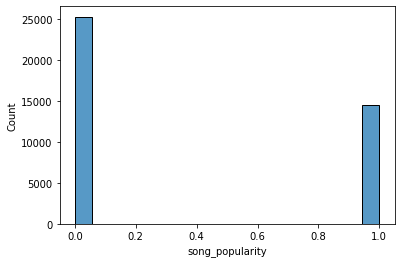

In [858]:
sns.histplot(data=full, x=target_col)

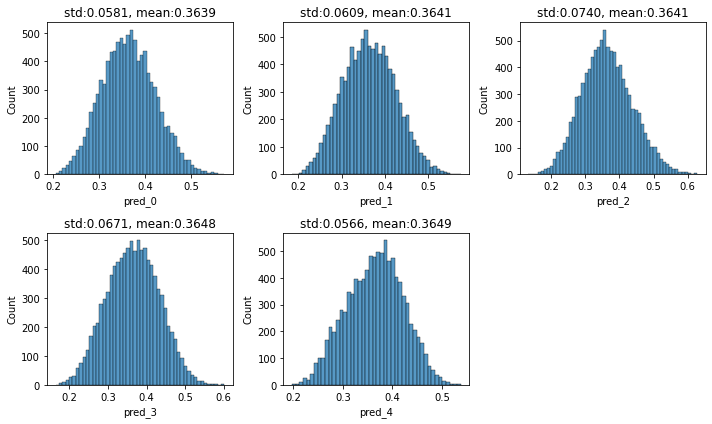

In [859]:
plt.figure(figsize=(10,6))
for i in range(len(cv_results['estimator'])):
  plt.subplot(2, 3, i+1)
  sns.histplot(data=test_preds, x=f'pred_{i}')
  std, mn = test_preds[f"pred_{i}"].std(), test_preds[f"pred_{i}"].mean()
  plt.title(f'std:{std:.4f}, mean:{mn:.4f}')
  plt.tight_layout()

In [885]:
result = test_preds[["id", target_col]]
result.columns = ['id', target_col]

In [886]:
result.head()

,id,song_popularity
0,0,0.418082
1,1,0.483789
2,2,0.313896
3,3,0.324908
4,4,0.377829


In [887]:
result.to_csv('submission.csv', index=False)

In [888]:
! kaggle competitions submit -c song-popularity-prediction -f submission.csv -m "HGB Trees RandomSearchCV, l2 regularisation"

100% 237k/237k [00:00<00:00, 945kB/s]
400 - Bad Request
